Подход к решению задачи:

1. Предобработка данных:
   - Объединение данных о триггерах и действиях
   - Создание признака времени с последнего триггера
   - Учет ограничения на частоту взаимодействия (14 дней)

2. Построение модели:
   - Использование XGBoost как лучшего алгоритма для бинарной классификации
   - Решение проблемы дисбаланса классов с помощью SMOTE и scale_pos_weight
   - Подбор гиперпараметров с помощью GridSearchCV

3. Оценка качества:
   - Использование метрик ROC AUC и F1-score(classification_report)
   - Анализ важности признаков

Обоснование:
- XGBoost выбран из-за высокой эффективности на табличных данных
- SMOTE применён для балансировки классов без потери информации
- Созданные признаки отражают временную динамику и частоту взаимодействий

### Импорт Библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set_palette("husl")

### Загрузка данных

In [2]:
actions = pd.read_csv('actions.csv')
triggers = pd.read_csv('triggers.csv')

### Предобработка данных

In [3]:
actions['date'] = pd.to_datetime(actions['date'])
triggers['date'] = pd.to_datetime(triggers['date'])

### Визуализация данных

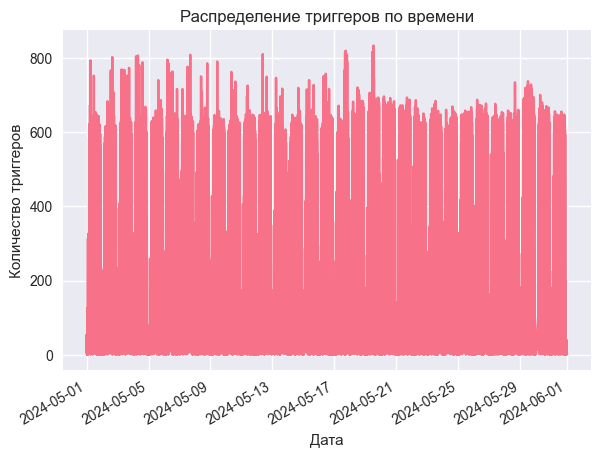

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
triggers['date'].value_counts().sort_index().plot()
plt.title('Распределение триггеров по времени')
plt.xlabel('Дата')
plt.ylabel('Количество триггеров')
plt.show()

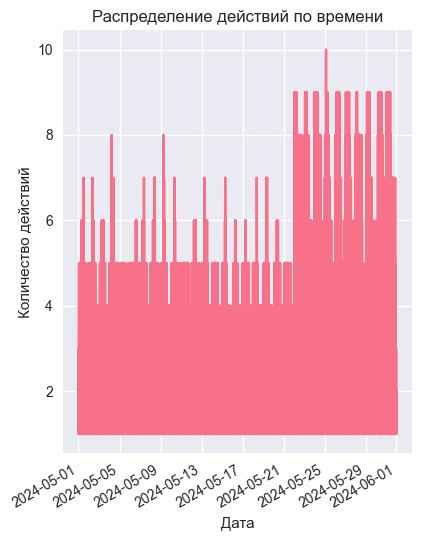

In [5]:
plt.subplot(1, 2, 2)
actions['date'].value_counts().sort_index().plot()
plt.title('Распределение действий по времени')
plt.xlabel('Дата')
plt.ylabel('Количество действий')
plt.tight_layout()
plt.show()

### Объединение датасетов 

In [6]:
data = triggers.merge(actions[['guid', 'date', 'result']], on=['guid', 'date'], how='left')

### Заполнение пропусков

In [7]:
data['result'] = data['result'].fillna(0) 

### Создание дополнительных признаков

In [8]:
data['time_since_last_trigger'] = data.groupby('guid')['date'].diff().dt.days.fillna(0)
data['is_repeat_trigger'] = (data['time_since_last_trigger'] < 14).astype(int)

### Подготовка к обучению

In [9]:
features = ['trigger', 'type', 'is_repeat_trigger', 'time_since_last_trigger']

In [10]:
X = data[features]
y = data['result']

### Балансировка классов с помощью SMOTE (т.к присутствует сильный дизбаланс)

In [11]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

### Разделение данных на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

### Еще раз баланс классов

In [13]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

### Создание модели (параметры были подобраны с помощью gridsearchcv)

In [14]:
model = XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight,
    max_depth=4,                
    min_child_weight=10,        
    subsample=0.8,               
    colsample_bytree=0.8,        
    random_state=42
)

### Обучение Модели

In [15]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Предикт модели

In [16]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

### Просмотр результатов

In [17]:
auc_train = roc_auc_score(y_train, pred_train)
auc_test = roc_auc_score(y_test, pred_test)
print('auc_train:', auc_train)
print('auc_test:', auc_test)

auc_train: 0.9105972887565028
auc_test: 0.9106427046375395


In [18]:
report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

In [19]:
print('\nReport train:', report_train)


Report train:               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91  34458336
         1.0       0.92      0.90      0.91  34461035

    accuracy                           0.91  68919371
   macro avg       0.91      0.91      0.91  68919371
weighted avg       0.91      0.91      0.91  68919371



In [20]:
print('\nReport test:', report_test)


Report test:               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91   8616271
         1.0       0.92      0.90      0.91   8613572

    accuracy                           0.91  17229843
   macro avg       0.91      0.91      0.91  17229843
weighted avg       0.91      0.91      0.91  17229843



In [21]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [22]:
print('Важность признаков')
print(feature_importance)

Важность признаков
                   feature  importance
3  time_since_last_trigger    0.478147
1                     type    0.276569
0                  trigger    0.245283
2        is_repeat_trigger    0.000000


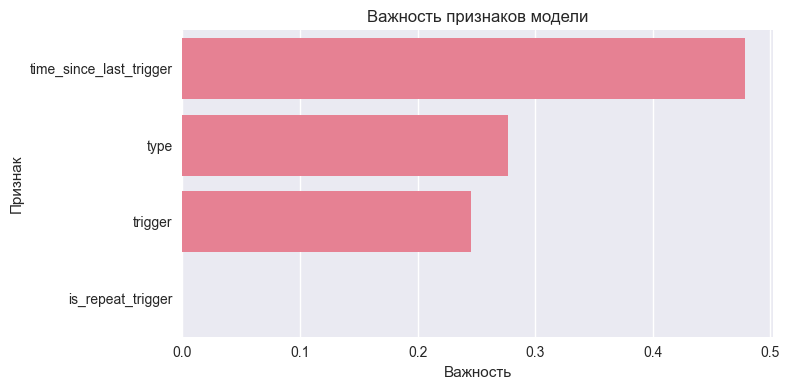

In [23]:
plt.figure(figsize=(8, 4))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков модели')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()